# U-Net

- Crop training images according to ground truth tumour area
- Standardise and resize
- One Hot Encoding

In [1]:
N_EPOCHS = 60
batch_size = 64
scan_type = 'Flair'

## Setup

In [2]:
import os, random, time
import numpy as np
import pandas as pd
import nibabel as nib
import cv2
import matplotlib.pyplot as plt

# Pytorch functions
import torch
# Neural network layers
import torch.nn as nn
import torch.nn.functional as F
# Optimizer
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset
# Torchvision library
from torchvision import transforms

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
# For results
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from torchsummary import summary

from utilities import *

In [3]:
# Device configuration
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
   device = torch.device('mps')
else:
    device = torch.device('cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

mps


In [4]:
def set_seed(seed, use_cuda = True, use_mps = False):
    """
    Set SEED for PyTorch reproducibility
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if use_cuda:
        torch.cuda.manual_seed_all(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    if use_mps:
        torch.mps.manual_seed(seed)

SEED = 44

USE_SEED = True

if USE_SEED:
    set_seed(SEED, torch.cuda.is_available(), torch.backends.mps.is_available())

In [5]:
train_images = np.sort([image for image in os.listdir(os.path.join('./BraTS/BraTS2021_Training_Data_2D_Unet', 'train', str(scan_type.lower()))) if image != '.DS_Store'])

## Define Custom Dataset

In [6]:
class BraTSDataset(Dataset):
    def __init__(self, image_path = './BraTS/BraTS2021_Training_Data_2D_Unet', subset = 'train', transform = None):
        'Initialisation'
        self.image_path = os.path.join(image_path, subset)
        self.image_names = np.sort([image for image in os.listdir(os.path.join(self.image_path, str(scan_type.lower()))) if image != '.DS_Store'])
        self.labels_names = np.sort([image for image in os.listdir(os.path.join(self.image_path, 'seg')) if image != '.DS_Store'])
        self.transform = transform
    
    def get_id(self, index):
        return self.image_names[index]

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.image_names)

    def __getitem__(self, index):
        'Generates one sample of data'

        # Select sample
        image_name = self.image_names[index]
        label_name = self.labels_names[index]
        
        path_img = os.path.join(self.image_path, str(scan_type.lower()), image_name)
        path_label = os.path.join(self.image_path, 'seg', label_name)
        image = np.load(path_img).astype(np.float32)
        label = np.load(path_label)
        
        if self.transform:
            image, label = self.transform([image, label])
        return image, label

In [7]:
class OneHotLabel(object):
    def __call__(self, sample):
        image, label = sample
        new_label = np.zeros((64,64,4)) # 0,1,2,4
        for i, l in enumerate([0,1,2,4]):
            new_label[:,:,i] = (label == l)
        return image, new_label

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, sample):
        image, label = sample
        image = np.float32(image)
        label = np.float32(label)

        # swap channel axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        new_label = label.transpose((2, 0, 1))
        return torch.from_numpy(image), torch.from_numpy(new_label)

In [8]:
dataset_train = BraTSDataset(transform = transforms.Compose([OneHotLabel(), ToTensor()]))
dataset_valid = BraTSDataset(subset = 'valid', transform = transforms.Compose([OneHotLabel(), ToTensor()]))
dataset_test = BraTSDataset(subset = 'test', transform = transforms.Compose([OneHotLabel(), ToTensor()]))

In [9]:
# Create the subset DataLoader
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

In [10]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        ## Input is 32 x 32 x 1
        ## Output is 32 x 32 x 4
        
        # Encoder
        # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image. 
        # Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, with the exception of the last block which does not include a max-pooling layer.
        # -------
        # input: 572x572x3 32 x 32 x 1
        self.e11 = nn.Conv2d(1, 64, kernel_size=3, padding=1) # output: 30x30x64
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 568x568x64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 284x284x64

        # input: 284x284x64
        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # output: 282x282x128
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 280x280x128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 140x140x128

        # input: 140x140x128
        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # output: 138x138x256
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # output: 136x136x256
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 68x68x256

        # input: 68x68x256
        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # output: 66x66x512
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output: 64x64x512
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 32x32x512

        # input: 32x32x512
        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1) # output: 30x30x1024
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1) # output: 28x28x1024


        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        # Output layer
        self.outconv = nn.Conv2d(64, 4, kernel_size=1)

    def forward(self, x):
        x = x.view(x.shape[0], 1, 64, 64)
        # Encoder
        xe11 = F.relu(self.e11(x))
        xe12 = F.relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = F.relu(self.e21(xp1))
        xe22 = F.relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = F.relu(self.e31(xp2))
        xe32 = F.relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = F.relu(self.e41(xp3))
        xe42 = F.relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = F.relu(self.e51(xp4))
        xe52 = F.relu(self.e52(xe51))
        
        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = F.relu(self.d11(xu11))
        xd12 = F.relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = F.relu(self.d21(xu22))
        xd22 = F.relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = F.relu(self.d31(xu33))
        xd32 = F.relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = F.relu(self.d41(xu44))
        xd42 = F.relu(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)

        return out

In [11]:
model = UNet().to(device)

print(f"The model has {count_parameters(model):,} trainable parameters.")

The model has 31,030,788 trainable parameters.


In [12]:
# Loss
# criterion = nn.CrossEntropyLoss() # Softmax + CrossEntropy
# criterion = nn.BCELoss()
criterion = torch.nn.BCEWithLogitsLoss()
criterion = criterion.to(device)

# Optim
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-3)

In [13]:
train_losses, train_accs, valid_losses, valid_accs,\
    train_losses_batch, train_accs_batch, valid_losses_batch, valid_accs_batch = model_training(N_EPOCHS,
                                                                                    model,
                                                                                    train_dataloader,
                                                                                    val_dataloader,
                                                                                    optimizer,
                                                                                    criterion,
                                                                                    device,
                                                                                    f'./models/UNet_{scan_type}.pt')

100.0 % loaded in this epoch for training

100.0 % loaded in this epoch for evaluation.

---------------------------------

Epoch: 1/60 -- Epoch Time: 498.91 s
Train -- Loss: 0.410, Acc: 80.39%
Val -- Loss: 0.289, Acc: 88.11%
100.0 % loaded in this epoch for training

100.0 % loaded in this epoch for evaluation.

---------------------------------

Epoch: 2/60 -- Epoch Time: 508.47 s
Train -- Loss: 0.284, Acc: 88.13%
Val -- Loss: 0.281, Acc: 88.18%
100.0 % loaded in this epoch for training

100.0 % loaded in this epoch for evaluation.

---------------------------------

Epoch: 3/60 -- Epoch Time: 513.05 s
Train -- Loss: 0.278, Acc: 88.26%
Val -- Loss: 0.276, Acc: 88.39%
100.0 % loaded in this epoch for training

100.0 % loaded in this epoch for evaluation.

---------------------------------

Epoch: 4/60 -- Epoch Time: 508.33 s
Train -- Loss: 0.274, Acc: 88.37%
Val -- Loss: 0.274, Acc: 88.44%
100.0 % loaded in this epoch for training

100.0 % loaded in this epoch for evaluation.

-------

In [14]:
os.makedirs('./results', exist_ok=True)

pd.DataFrame({
    'Train Loss': train_losses,
    'Train Acc': train_accs,
    'Valid Loss': valid_losses,
    'Valid Acc': valid_accs
}).to_csv(f'./results/Unet_{scan_type}.csv', index = False)

In [15]:
stacked_df = pd.concat([pd.DataFrame(pd.DataFrame(train_losses_batch).values.flatten(), columns=['Train Loss']),
                        pd.DataFrame(pd.DataFrame(train_accs_batch).values.flatten(), columns=['Train Acc']),
                        pd.DataFrame(pd.DataFrame(valid_losses_batch).values.flatten(), columns=['Valid Loss']),
                        pd.DataFrame(pd.DataFrame(valid_accs_batch).values.flatten(), columns=['Valid Acc'])], axis=1)
stacked_df.to_csv(f'./results/Unet_{scan_type}_batch.csv', index = False)

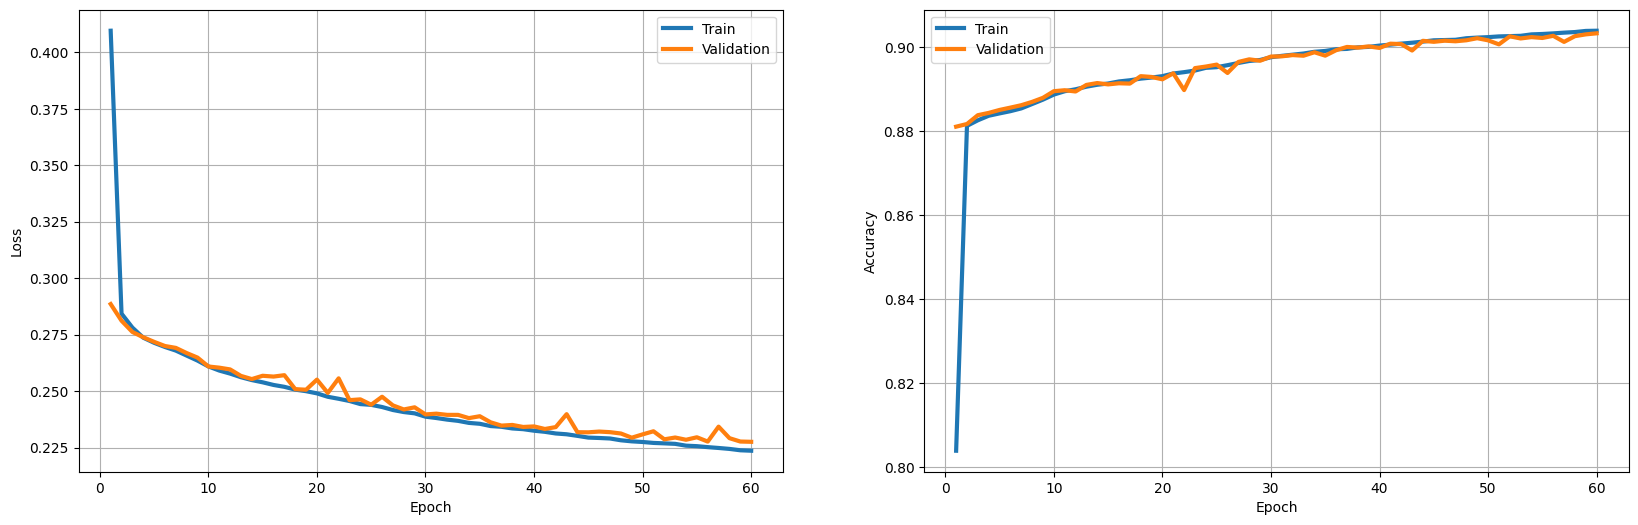

In [16]:
plot_results(N_EPOCHS, train_losses, train_accs, valid_losses, valid_accs)

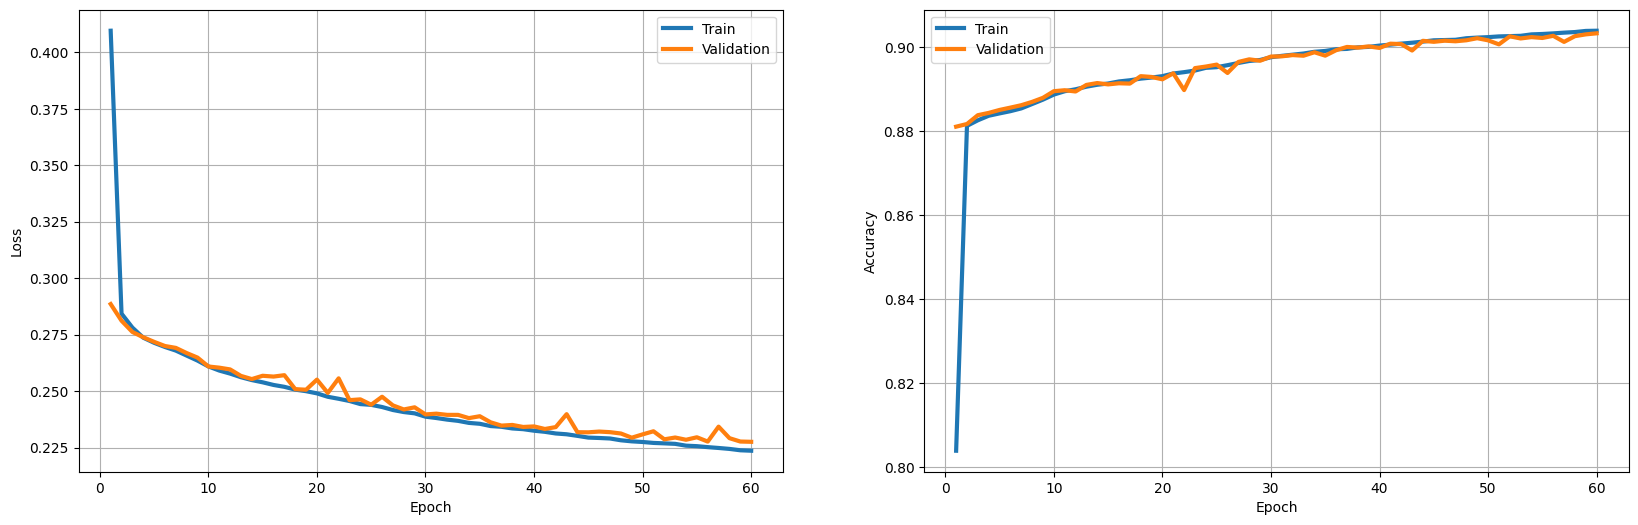

In [17]:
plot_results(N_EPOCHS, train_losses, train_accs, valid_losses, valid_accs)

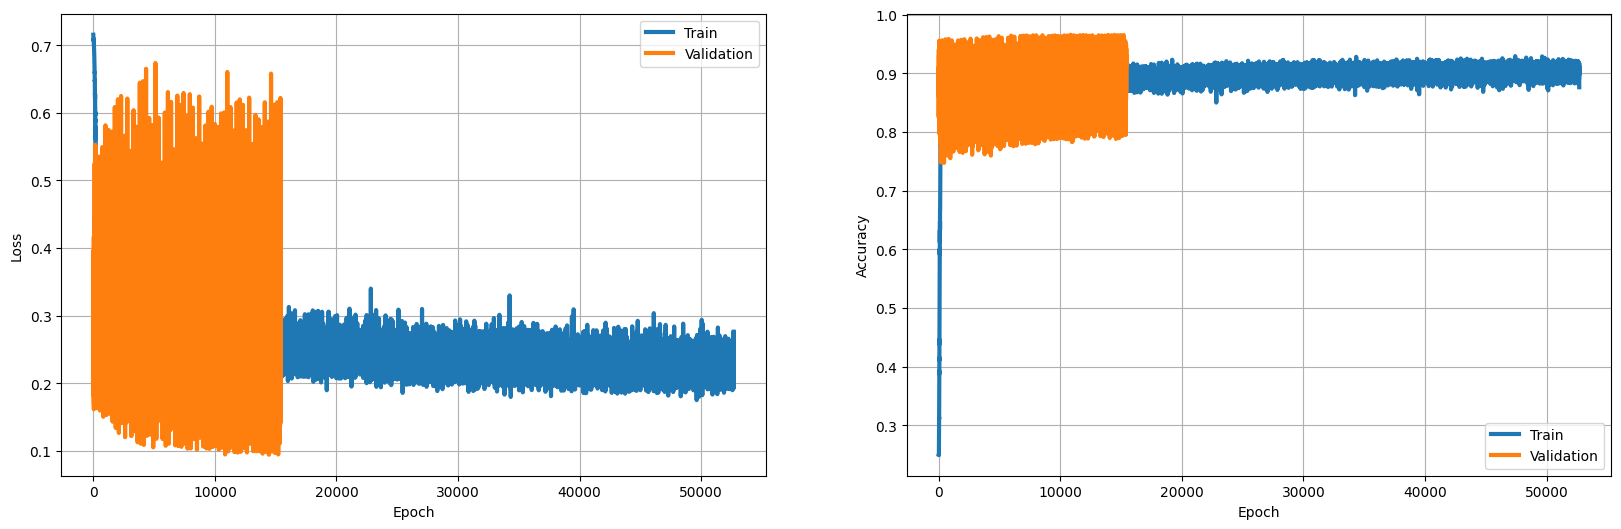

In [18]:
# Plot results
plt.figure(figsize=(20, 6))
_ = plt.subplot(1,2,1)
plt.plot(np.arange(len(stacked_df['Train Loss']))+1, stacked_df['Train Loss'], linewidth=3)
plt.plot(np.arange(len(stacked_df['Valid Loss']))+1, stacked_df['Valid Loss'], linewidth=3)
_ = plt.legend(['Train', 'Validation'])
plt.grid('on'), plt.xlabel('Epoch'), plt.ylabel('Loss')

_ = plt.subplot(1,2,2)
plt.plot(np.arange(len(stacked_df['Train Acc']))+1, stacked_df['Train Acc'], linewidth=3)
plt.plot(np.arange(len(stacked_df['Valid Acc']))+1, stacked_df['Valid Acc'], linewidth=3)
_ = plt.legend(['Train', 'Validation'])
plt.grid('on'), plt.xlabel('Epoch'), plt.ylabel('Accuracy')

plt.show()

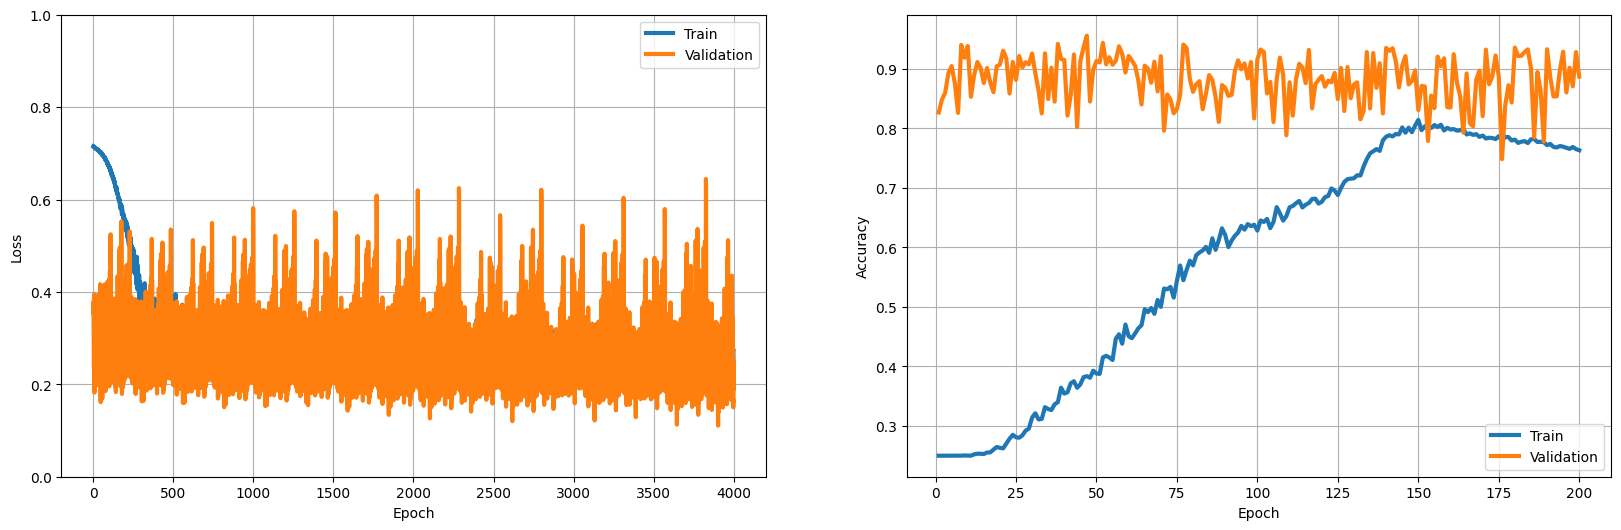

In [19]:
# Plot results
plt.figure(figsize=(20, 6))
_ = plt.subplot(1,2,1)
plt.plot(np.arange(4000)+1, stacked_df['Train Loss'][:4000], linewidth=3)
plt.plot(np.arange(4000)+1, stacked_df['Valid Loss'][:4000], linewidth=3)
plt.ylim(0,1)
_ = plt.legend(['Train', 'Validation'])
plt.grid('on'), plt.xlabel('Epoch'), plt.ylabel('Loss')

_ = plt.subplot(1,2,2)
plt.plot(np.arange(200)+1, stacked_df['Train Acc'][:200], linewidth=3)
plt.plot(np.arange(200)+1, stacked_df['Valid Acc'][:200], linewidth=3)
_ = plt.legend(['Train', 'Validation'])
plt.grid('on'), plt.xlabel('Epoch'), plt.ylabel('Accuracy')

plt.show()

# Prediction

In [ ]:
# Change the print options for PyTorch tensors
torch.set_printoptions(threshold=10_000)
# Reset print options to default if desired
torch.set_printoptions(threshold=1000)

In [ ]:
model.load_state_dict(torch.load(f'./models/Unet_{scan_type}.pt'))
model.to(device)

In [ ]:
labels, preds = predict(model, test_dataloader, device)

In [163]:
# folders = [folder for folder in os.listdir(os.path.join('./BraTS', 'BraTS2021_Training_Data')) if folder != '.DS_Store']
# def index_converter(index):
#     return index // 155, index % 155 # image_idx, layer_idx

In [165]:
# dataset_size = len(folders)
# dataset_indices = list(range(dataset_size))

# train_indices, test_indices = train_test_split(dataset_indices, test_size=0.1, random_state=SEED)
# train_indices, val_indices = train_test_split(train_indices, test_size=0.22, random_state=SEED)

# tmp_list = [[],[],[]]
# for i, ind_list in enumerate([train_indices, val_indices, test_indices]):
#     for ind in ind_list:
#         for j in range(155):
#             tmp_list[i].append(ind*155 + j)
# train_indices, val_indices, test_indices = tmp_list

For example, we want to see the $231^{st}$ test data

In [168]:
img = 230 # id in test set

In [167]:
# image_id, slice_no = index_converter(test_indices[img])
# print(f"Image ID: {image_id}, Slice No: {slice_no}")

Image ID: 481, Slice No: 75


In [169]:
pred = torch.argmax(preds[img], dim=0)
label = torch.argmax(labels[img], dim=0)

# Re-label class '3' to '4'
pred = torch.where(pred == 3, torch.tensor(4), pred)
label = torch.where(label == 3, torch.tensor(4), label)

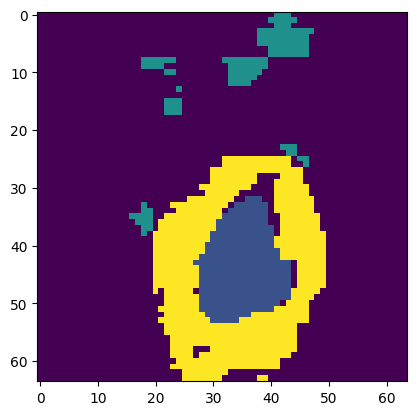

In [170]:
plt.imshow(pred)

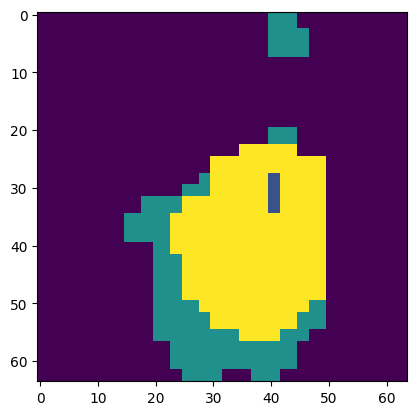

In [171]:
plt.imshow(label)

We can see the original data and their cropped area

In [204]:
image_id, slice_no = [os.path.splitext(dataset_test.get_id(img))[0].split('_')[i] for i in [1,3]]

In [213]:
crop_region = np.load(f'./BraTS/BraTS2021_Training_Data_2D_Unet/test/cropped_area/BraTS2021_{str(image_id).zfill(5)}_area_{slice_no}.npy')
crop_region

array([27, 52, 12, 37])

In [208]:
org_image = np.load(f'./BraTS/BraTS2021_Training_Data_2D/BraTS2021_{str(image_id).zfill(5)}/{scan_type.lower()}/BraTS2021_{str(image_id).zfill(5)}_{scan_type.lower()}_{slice_no}.npy')
org_label = np.load(f'./BraTS/BraTS2021_Training_Data_2D/BraTS2021_{str(image_id).zfill(5)}/seg/BraTS2021_{str(image_id).zfill(5)}_seg_{slice_no}.npy')

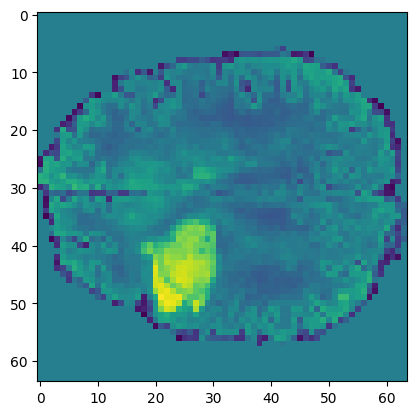

In [210]:
plt.imshow(org_image)

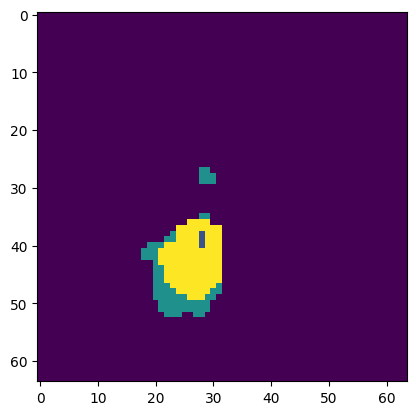

In [211]:
plt.imshow(org_label)